In this notebook, we will build a 3D map of a scene from a small set of images and refine it with the featuremetric optimization. We then localize an image downloaded from the Internet and show the effect of the refinement.

In [1]:
# %load_ext autoreload
# %autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, pairs_from_exhaustive, visualization
from hloc.visualization import plot_images, read_image
from hloc.utils.viz_3d import init_figure, plot_points, plot_reconstruction, plot_camera_colmap

from pixsfm.util.visualize import init_image, plot_points2D
from pixsfm.refine_hloc import PixSfM
from pixsfm import ostream_redirect

# redirect the C++ outputs to notebook cells
cpp_out = ostream_redirect(stderr=True, stdout=True)
cpp_out.__enter__()

# Setup
We start by defining some output paths: where the intermediate files will be stored.

In [2]:
images = Path('datasets/sacre_coeur')
outputs = Path('outputs/demo/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
raw_dir = outputs / "raw"
ref_dir = outputs / "ref"

Here we will use SuperPoint local features with the SuperGlue matcher, but it's easy to switch to other features like SIFT or R2D2.

In [3]:
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping and refinement
First we list the images used for mapping. These are all day-time shots of Sacre Coeur.

10 mapping images


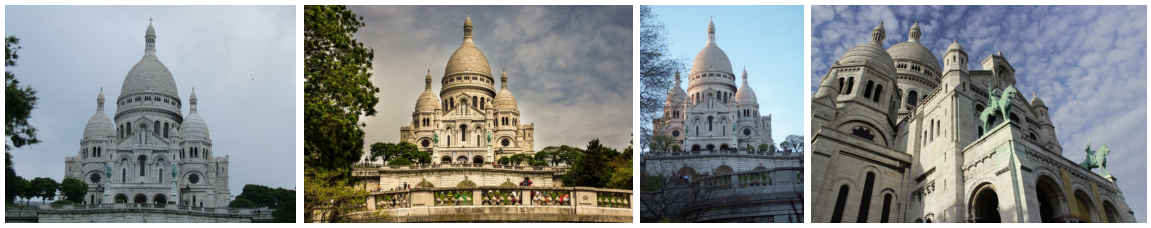

In [4]:
references = [str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

Then we extract features and match them across image pairs. Since we deal with few images, we simply match all pairs exhaustively.

In [5]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

[2023/12/11 23:43:13 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/10 [00:00<?, ?it/s]

[2023/12/11 23:43:15 hloc INFO] Finished exporting features.
[2023/12/11 23:43:15 hloc INFO] Found 45 pairs.
[2023/12/11 23:43:15 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/45 [00:00<?, ?it/s]

[2023/12/11 23:43:19 hloc INFO] Finished exporting matches.


PosixPath('outputs/demo/matches.h5')

In [6]:
from pixsfm.refine_hloc import PixSfM
from pixsfm.util.hloc import read_keypoints_hloc
# features = outputs / 'features.h5'
# matches = outputs / 'matches.h5'
print(outputs)

# with open(sfm_pairs, "r") as f:
#     contents = f.read()
#     print(contents)
refiner = PixSfM()
keypoints_new, ka_data, feature_manager = refiner.refine_keypoints(
    outputs / 'features_refined.h5',
    features,
    images,
    sfm_pairs,
    matches,
    
)
print(ka_data['summary'])
print(feature_manager)
# keypoints_old = read_keypoints_hloc(features)

# from pixsfm.refine_hloc import PixSfM
# refiner = PixSfM()
# keypoints, _, _ = refiner.refine_keypoints(
#     path_to_output_keypoints.h5,
#     path_to_input_keypoints.h5,
#     path_to_list_of_image_pairs,
#     path_to_matches.h5,
#     path_to_image_dir,
# )
# print(keypoints_old)

outputs/demo


[2023/12/11 23:43:21 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/maij/text3d/sparf/third_party/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2023/12/11 23:43:21 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1600,
 'model': {'name': 's2dnet'},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}
[2023/12/11 23:43:21 pixsfm INFO] Building matching graph...
[2023/12/11 23:43:21 pixsfm INFO] Extracting dense features...


  0%|          | 0/10 [00:00<?, ?it/s]

[2023/12/11 23:43:22 pixsfm INFO] Computing tracks...
[2023/12/11 23:43:22 pixsfm INFO] # graph nodes: 10926
[2023/12/11 23:43:22 pixsfm INFO] # graph edges: 17937
[2023/12/11 23:43:22 pixsfm INFO] # tracks: 3224
[2023/12/11 23:43:22 pixsfm INFO] Start feature-metric keypoint adjustment.


100%[████████████████████] 10926/10926 [00:00, 20654.0it/s]


[2023/12/11 23:43:23 pixsfm INFO] KA Time: 0.529011s, cost change: 0.0232752 --> 0.0215056


In [9]:
"""
    To conclude, KA won't change the older of the keypoints, so the matching won't be changed.
    however, the coordinates can be changed
"""
keypoints_old = read_keypoints_hloc(features)
knew=dict(keypoints_new)
kold=keypoints_old
import numpy as np
for k in kold.keys():
    k='mapping/03903474_1471484089.jpg'
    print(len(kold[k]),len(knew[k]))
    print(k)
    print(kold[k].dtype, kold[k].shape)
    arr=kold[k]
    sorted_indices = np.lexsort((arr[:, 1], arr[:, 0]))
    sorted_arr = arr[sorted_indices]
    print("old",sorted_arr)
    
    arr=knew[k]
    sorted_indices = np.lexsort((arr[:, 1], arr[:, 0]))
    sorted_arr = arr[sorted_indices]
    print("new",sorted_arr)
    print(arr)
    
    arr=knew[k]-kold[k]
    sorted_indices = np.lexsort((arr[:, 1], arr[:, 0]))
    sorted_arr = arr[sorted_indices]
    print("diff",sorted_arr)
    print(arr)
    break

1783 1783
mapping/03903474_1471484089.jpg
float64 (1783, 2)
old [[  10.578125  497.75    ]
 [  11.625     647.5     ]
 [  14.796875  682.5     ]
 ...
 [1067.        548.5     ]
 [1071.        392.25    ]
 [1071.        569.5     ]]
new [[  10.578125  497.75    ]
 [  11.625     647.5     ]
 [  14.796875  682.5     ]
 ...
 [1067.        548.5     ]
 [1071.        392.25    ]
 [1071.        569.5     ]]
[[ 408.25         13.734375  ]
 [ 540.37103036   16.24240839]
 [ 173.63707609   21.18695309]
 ...
 [1008.5         682.5       ]
 [1026.          682.5       ]
 [1042.          682.5       ]]
diff [[-4.         -4.        ]
 [-4.         -2.60016093]
 [-4.         -0.55536301]
 ...
 [ 4.         -0.40330218]
 [ 4.          1.18547882]
 [ 4.          2.7820341 ]]
[[ 0.          0.        ]
 [ 1.37103036 -1.71071661]
 [-0.36292391  0.06195309]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]


Now we run the reconstruction with and without the featuremetric refinement. For this dataset, when computing the dense features, we resize the images such that they are not larger than 1024 pixels.

In [ ]:
# run pixsfm
sfm = PixSfM({"dense_features": {"max_edge": 1024}})
refined, sfm_outputs = sfm.reconstruction(ref_dir, images, sfm_pairs, features, matches, image_list=references)
# here ref is pycolmap.Reconstruction object

# run the raw geometric SfM for comparison
raw_sfm = PixSfM({"KA":{"apply": False}, "BA": {"apply": False}})
raw, _ = raw_sfm.reconstruction(raw_dir, images, sfm_pairs, features, matches, image_list=references)

`refined` and `raw` are `pycolmap.Reconstruction` objects, of which we can print the statistics to compare them:

In [7]:
print("Raw", raw.summary())
print("Refined", refined.summary())

Raw Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 1929
	num_observations = 8261
	mean_track_length = 4.28253
	mean_observations_per_image = 826.1
	mean_reprojection_error = 0.997768
Refined Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 1856
	num_observations = 8076
	mean_track_length = 4.35129
	mean_observations_per_image = 807.6
	mean_reprojection_error = 0.812517


# Visualization
To visualize both models together, we rigidly transform the raw reconstruction so that the 3D points common to the two 3D models are aligned.

In [8]:
raw.align_points(refined, max_error=0.005, min_inlier_ratio=0.9, min_overlap=3)

Found 882 / 1929 valid correspondences.


SimilarityTransform3:
  0.789681   0.251901   0.601836  -0.476712
 -0.209982   0.992756      -0.14   0.158075
 -0.617712 -0.0154434   0.816976   0.486431
         0          0          0          1

We now plot the reconstructions side-by-side. We can click on the legend entries to toggle them.

In [ ]:
fig3d = init_figure()
args = dict(max_reproj_error=3.0, min_track_length=2, cs=1)
plot_reconstruction(fig3d, raw, color='rgba(255, 0, 0, 0.5)', name="raw", **args)
plot_reconstruction(fig3d, refined, color='rgba(0, 255, 0, 0.5)', name="refined", **args)
fig3d.show()

We can also visualize the detected keypoints (blue) and the final reprojections (red) for a given mapping image. You can drag to zoom in. As you can see, the points were refined by a few pixels at most but the 3D points and camera poses can be refined up to a few meters.

In [ ]:
img = refined.images[refined.reg_image_ids()[0]]
cam = refined.cameras[img.camera_id]
fig = init_image(images / img.name)    
plot_points2D(fig, [p2D.xy for p2D in img.points2D if p2D.has_point3D()])
plot_points2D(fig, cam.world_to_image(img.project(refined)), color='rgba(255, 0, 0, 0.5)')
fig.show()

# Localization
Now that we have a 3D map of the scene, we can localize any image. To demonstrate this, we download [a night-time image from Wikimedia](https://commons.wikimedia.org/wiki/File:Paris_-_Basilique_du_Sacr%C3%A9_Coeur,_Montmartre_-_panoramio.jpg).

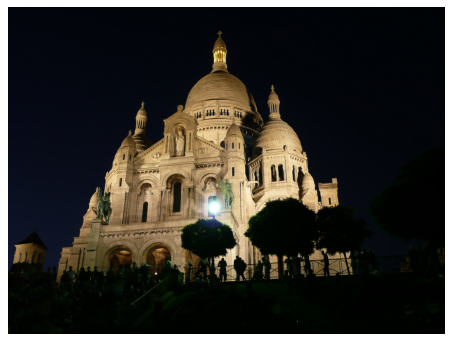

In [11]:
url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Paris_-_Basilique_du_Sacr%C3%A9_Coeur%2C_Montmartre_-_panoramio.jpg"
# try other queries by uncommenting their url
# url = "https://upload.wikimedia.org/wikipedia/commons/8/8e/Sacr%C3%A9_C%C5%93ur_at_night%21_%285865355326%29.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/c/c0/La_basilique_du_Sacr%C3%A9-Coeur_au_cr%C3%A9puscule_%28Paris%29_%284147593805%29.jpg"
query = 'query/night.jpg'
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

Again, we extract features for the query and match them exhaustively with all mapping images that were successfully reconstructed.

In [12]:
references_registered = [refined.images[i].name for i in refined.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2022/01/21 15:23:55 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2022/01/21 15:23:55 hloc INFO] Finished exporting features.
[2022/01/21 15:23:55 hloc INFO] Found 10 pairs.
[2022/01/21 15:23:55 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


  0%|          | 0/10 [00:00<?, ?it/s]

[2022/01/21 15:23:56 hloc INFO] Finished exporting matches.


We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters. Under the hood, the `QueryLocalizer` takes care of extracting dense features for the query and runs the keypoint and pose adjustments, QKA and QBA. The refinement refines the camera parameters in-place so we can inspect them.

[2022/01/21 15:23:57 pixsfm.features.models.s2dnet INFO] Loading S2DNet checkpoint at /home/psarlin/work/geometry/pixel-perfect-sfm/pixsfm/features/models/checkpoints/s2dnet_weights.pth.
[2022/01/21 15:23:57 pixsfm INFO] Loaded dense extractor with configuration:
{'cache_format': 'chunked',
 'device': 'auto',
 'dtype': 'half',
 'fast_image_load': False,
 'l2_normalize': True,
 'load_cache_on_init': False,
 'max_edge': 1024,
 'model': {'name': 's2dnet', 'num_layers': 1, 'checkpointing': None, 'output_dim': 128, 'pretrained': 's2dnet', 'remove_pooling_layers': False, 'combine': False},
 'overwrite_cache': False,
 'patch_size': 16,
 'pyr_scales': [1.0],
 'resize': 'LANCZOS',
 'sparse': True,
 'use_cache': False}


[2022/01/21 15:23:57 pixsfm INFO] Extracting references.


100%[████████████████████] 1856/1856 [00:00, 88380.9it/s]


[2022/01/21 15:23:57 pixsfm INFO] Reference Extraction Time: 0.024502s
[2022/01/21 15:23:58 pixsfm INFO] QKA Time: 0.374653s, cost change: 0.071459 --> 0.0644741


[2022/01/21 15:23:58 pixsfm INFO] Running PnP with 1126 correspondences.


[2022/01/21 15:23:58 pixsfm INFO] QBA Time: 0.203035s, cost change: 0.0266638 --> 0.0266623
found 531/1126 inlier correspondences.


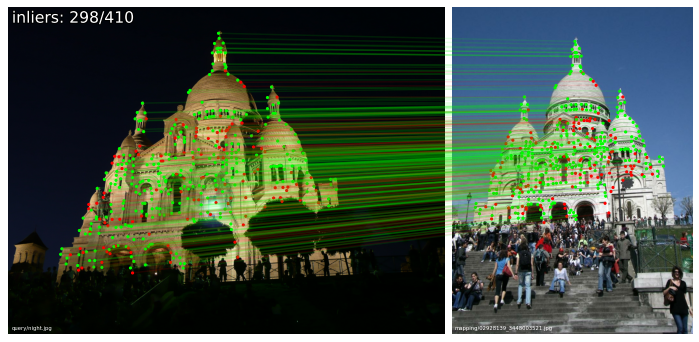

In [13]:
import pycolmap
from pixsfm.localize import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [refined.find_image_with_name(r).image_id for r in references_registered]
conf = {
    "dense_features": sfm.conf.dense_features,  # same features as the SfM refinement
    "PnP": {  # initial pose estimation with PnP+RANSAC
        'estimation': {'ransac': {'max_error': 12.0}},
        'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
    },
    "QBA": {  # query pose refinement
        "optimizer:": {'refine_focal_length': True, 'refine_extra_params': True},
    }
}
dense_features = sfm_outputs["feature_manager"]
localizer = QueryLocalizer(refined, conf, dense_features=dense_features)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches, image_path=images/query)

print(f'found {sum(ret["inliers"])}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, refined, top_k_db=1)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map, shown here in blue.

In [ ]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
plot_camera_colmap(fig3d, pose, camera, color='rgba(128,128,255,0.5)', name=query, legendgroup="refined")
fig3d.show()